In [1]:
import os

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import argparse
import joblib
import tensorflow as tf
import math
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


2023-08-17 13:52:21.378131: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-17 13:52:21.405250: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-17 13:52:22.332579: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# HIDDEN FUNCTION

## Utils

In [2]:
import os
import numpy as np
import tensorflow as tf

#---------------------------------------------------------------------------------------------------------------------
# CREATE TRAIN-TEST SPLIT (80:20)
#---------------------------------------------------------------------------------------------------------------------
def np_array_convert(dataset, prev, pred):
    dataX, dataY = [], []

    for col_index in range( len(dataset.columns) ):
        col = dataset[dataset.columns[col_index]]
        
        for i in range(len(dataset) - prev - pred + 1):
            a = col.iloc[i:(i+prev)]
            dataX.append(a)
            dataY.append(col.iloc[i + prev: i + prev + pred])

    return (np.array(dataX), np.array(dataY))


#-----------------------------------------------------------
# USING A LSTM MODEL FOR PREDICTION ON TIME SERIES
#-----------------------------------------------------------
def model_setup(x_train_scale, pred_day):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(512,input_shape=(x_train_scale.shape[1], 1),return_sequences=True))
    model.add(tf.keras.layers.LSTM(512,return_sequences=False))
    model.add(tf.keras.layers.Dense(pred_day))

    # model.summary()

    model.compile(loss='mean_absolute_error', optimizer= tf.keras.optimizers.Adam())

    return model


#-----------------------------------------------------------
# DEFINING CALLBACKS
#-----------------------------------------------------------
def callback_setup():
    es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
    lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)


    checkpoint_path = "./checkpoint/cp"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1, 
        save_weights_only=True,
        save_freq=999999)
    
    return [es , lr_red, cp_callback]

## eval

In [3]:
def read_data(filename):
    df = pd.read_csv(filename)
    df = df.set_index('timestamp')
    return df


#------------------------------------------------------------------------------------
# Transform DataFrame into format expected by model for evaluation
#------------------------------------------------------------------------------------

def transform_data(df, prev_day, pred_day, scaler_path):

    # Chunk datafram into Features (number of days that model needs to know) and Labels (number of days model can predict)
    x_test, y_test = np_array_convert(df, prev = prev_day, pred = pred_day)


    # Normalize the data using the saved the parameters of normalization
    scaler = MinMaxScaler(feature_range=(0, 1))

    scaler = joblib.load(scaler_path + '/scaler_features.pkl')
    x_test_scale = scaler.transform(pd.DataFrame(x_test))

    scaler = joblib.load(scaler_path + '/scaler_labels.pkl')
    y_test_scale = scaler.transform(pd.DataFrame(y_test))

    return x_test, y_test, x_test_scale, y_test_scale

#------------------------------------------------------------------------------------
# Print the test results
#------------------------------------------------------------------------------------

def test_score(preds, y_test, pred_day):

    # mean_squared_error
    testScore_1 = math.sqrt(mean_squared_error(y_test[:], preds[:]))
    print('Test Score: %.2f RMSE' % (testScore_1))

    # mean_absolute_error
    testScore_2 = math.sqrt(mean_absolute_error(y_test[:], preds[:]))
    print('Test Score: %f MAE' % (testScore_2))

    # MAPE
    testScore_3 = np.mean(np.abs(preds - y_test)/np.abs(y_test)*100)
    print('Test Score: %f MAPE' % (testScore_3))


    # mean absolute mean error
    arr = 1 - abs(y_test[:] - preds[:])/y_test[:]
    arr = arr = np.where(arr < 0, 0, arr)
    acc = sum(sum(arr)/len(y_test))/pred_day

    print("*** Accuracy: ", acc * 100)

# VARIABLES

In [4]:
eval_path = "../data/preprocess_data/ram/test.csv"

model_path = "../model/ram/12H"
scaler_path = model_path + "/scaler"
prev_day = 12
pred_day = 2

<Axes: xlabel='timestamp'>

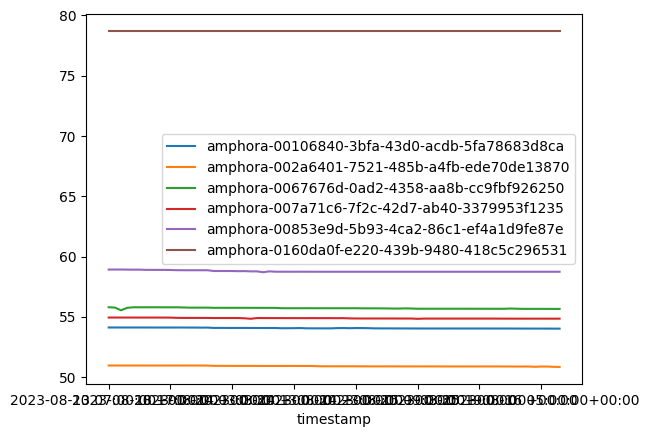

In [5]:
df = pd.read_csv(eval_path)
df = df.set_index('timestamp')
df.plot()

# Visualization

In [6]:
x_test, y_test, x_test_scale, y_test_scale = transform_data(df, prev_day, pred_day, scaler_path)

model = model_setup(x_test_scale, pred_day)
model = tf.keras.models.load_model(model_path)

preds = model.predict(x_test_scale)
scaler = joblib.load(scaler_path + '/scaler_labels.pkl')
preds = scaler.inverse_transform(preds)

test_score(preds, y_test, pred_day)

2023-08-17 13:52:24.159603: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-17 13:52:24.178526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-17 13:52:24.178642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

12/12 [==============================] - 0s 2ms/step
Test Score: 1.65 RMSE
Test Score: 1.011115 MAE
Test Score: 1.497536 MAPE
*** Accuracy:  98.50246377050235


2023-08-17 13:52:26.130278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-17 13:52:26.154432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [7]:
s = pd.Series(df.index[prev_day+pred_day:])
test0 = pd.DataFrame(df[ df.columns[0] ])
test1 = pd.DataFrame(df[ df.columns[1] ])
test2 = pd.DataFrame(df[ df.columns[2] ])
test3 = pd.DataFrame(df[ df.columns[3] ])
test4 = pd.DataFrame(df[ df.columns[4] ])

In [8]:
def eval_each_type(test_type, prev_day, pred_day, scaler_path, model):
    x_test, y_test, x_test_scale, y_test_scale = transform_data(test_type, prev_day, pred_day, scaler_path)
    # print(y_test)

    scaler = joblib.load(scaler_path + '/scaler_labels.pkl')
    preds = model.predict(x_test_scale)
    preds = scaler.inverse_transform(preds)

    plt.rcParams["figure.figsize"] = (32,12)

    TestY= pd.DataFrame(y_test,columns=[str(i) for i in range(pred_day)])
    PredY= pd.DataFrame(preds, columns=[str(i) for i in range(pred_day)])

    plot_max = plt.figure(6)
    plt.plot(TestY['0'])
    plt.plot(PredY['0'])

    plt.show()

2/2 [==============================] - 0s 2ms/step


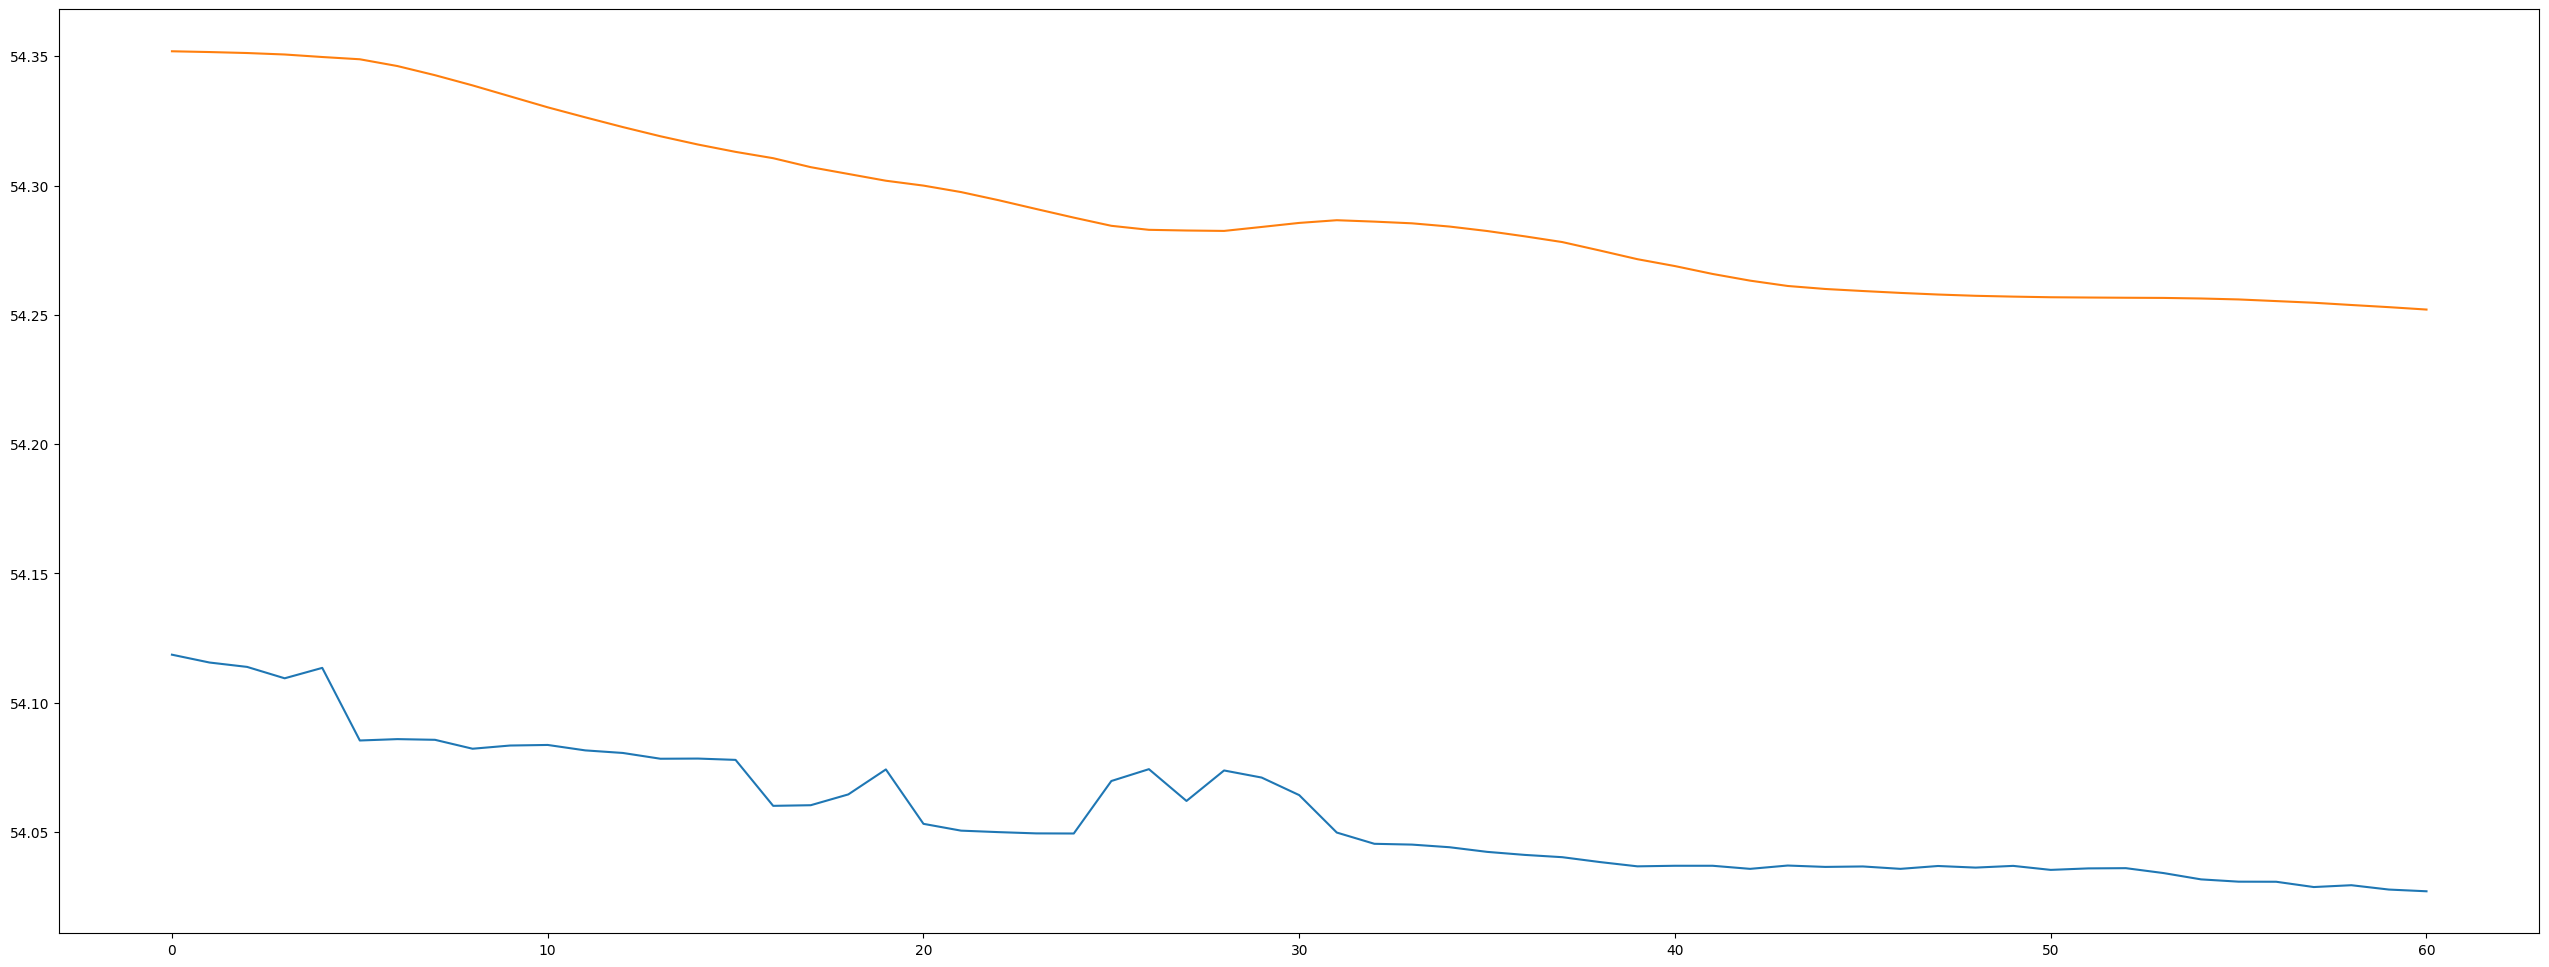

2/2 [==============================] - 0s 2ms/step


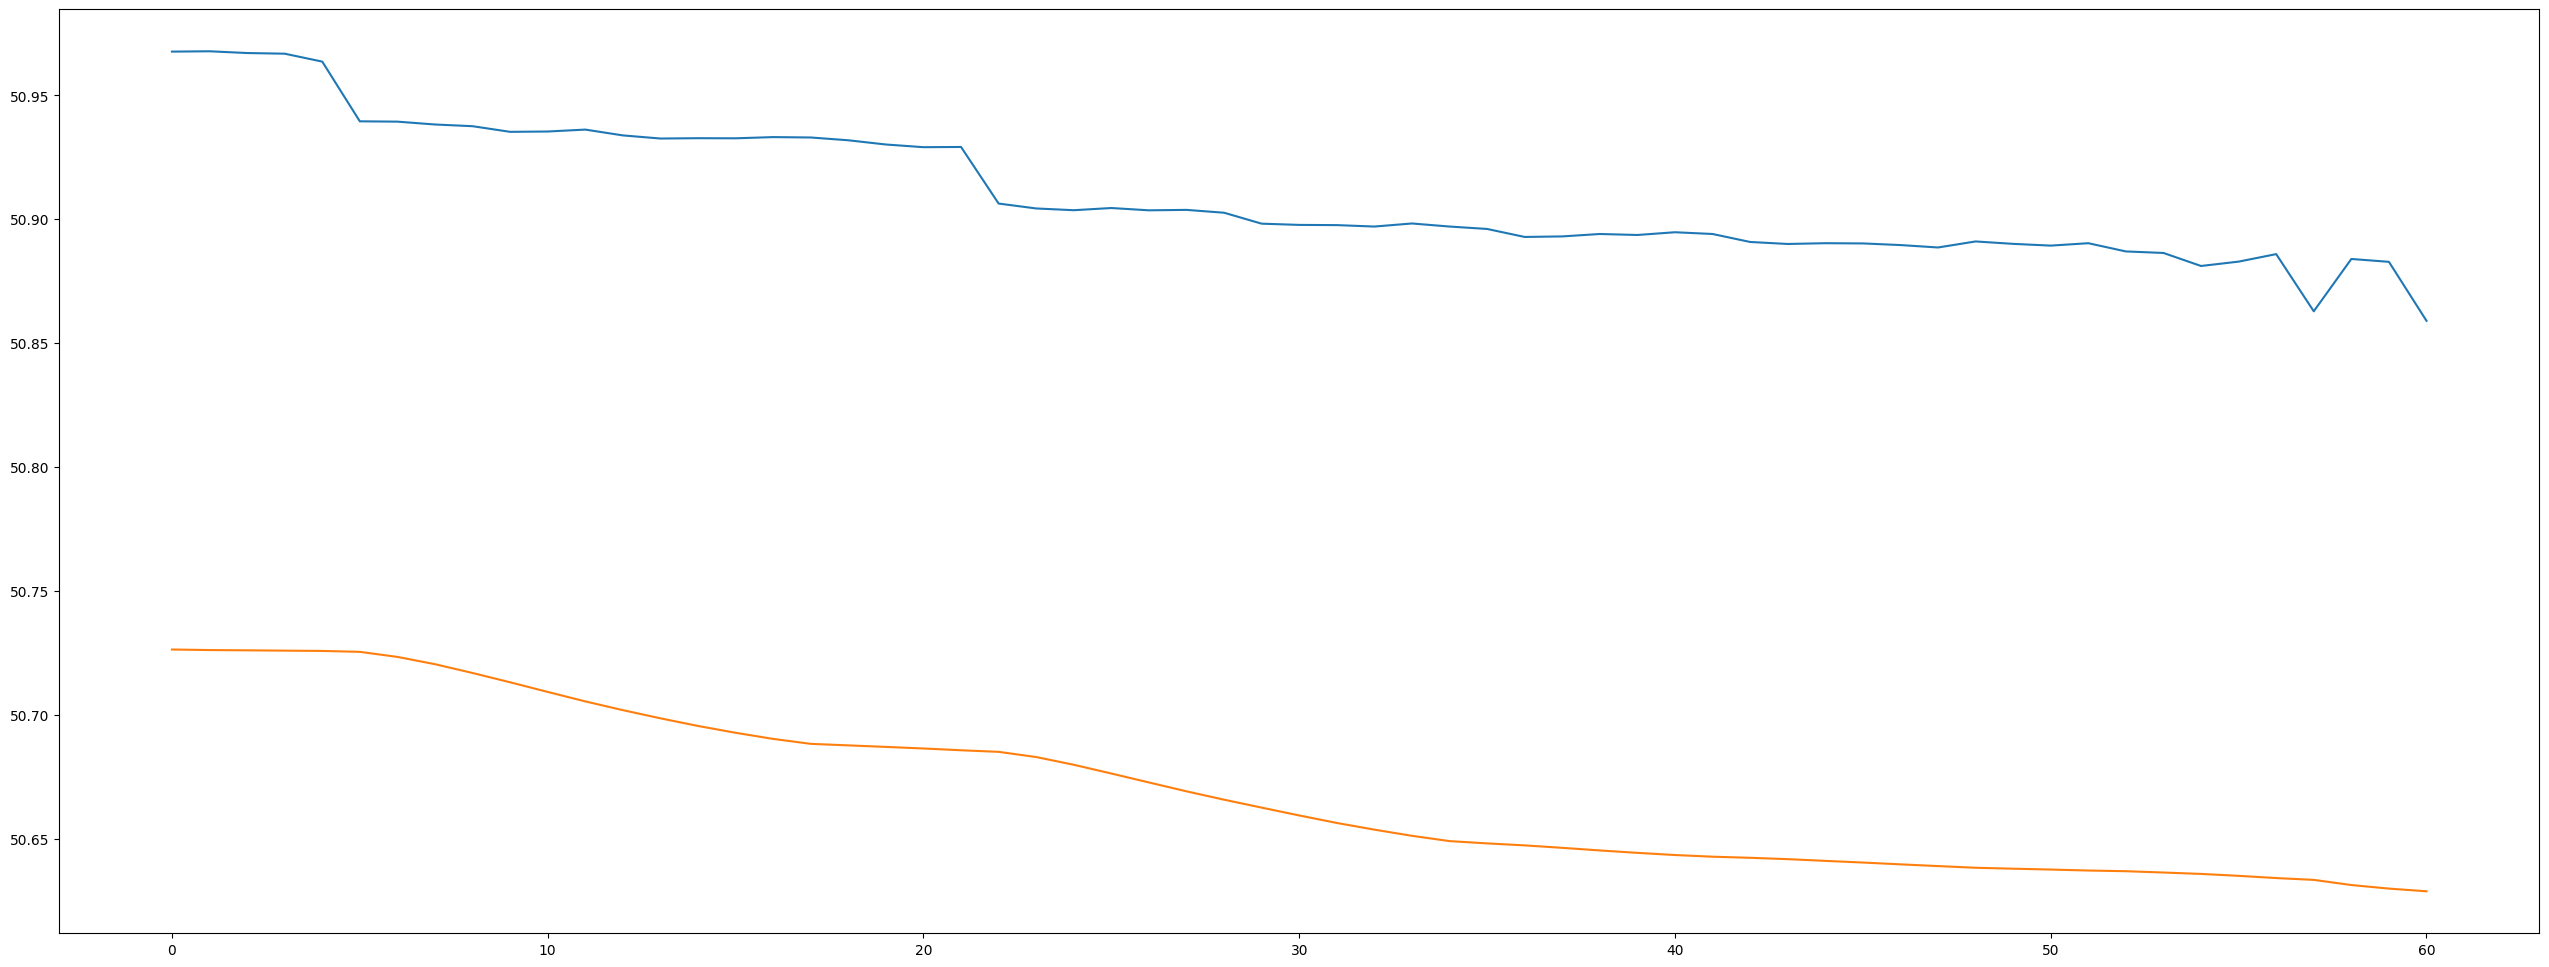

2/2 [==============================] - 0s 2ms/step


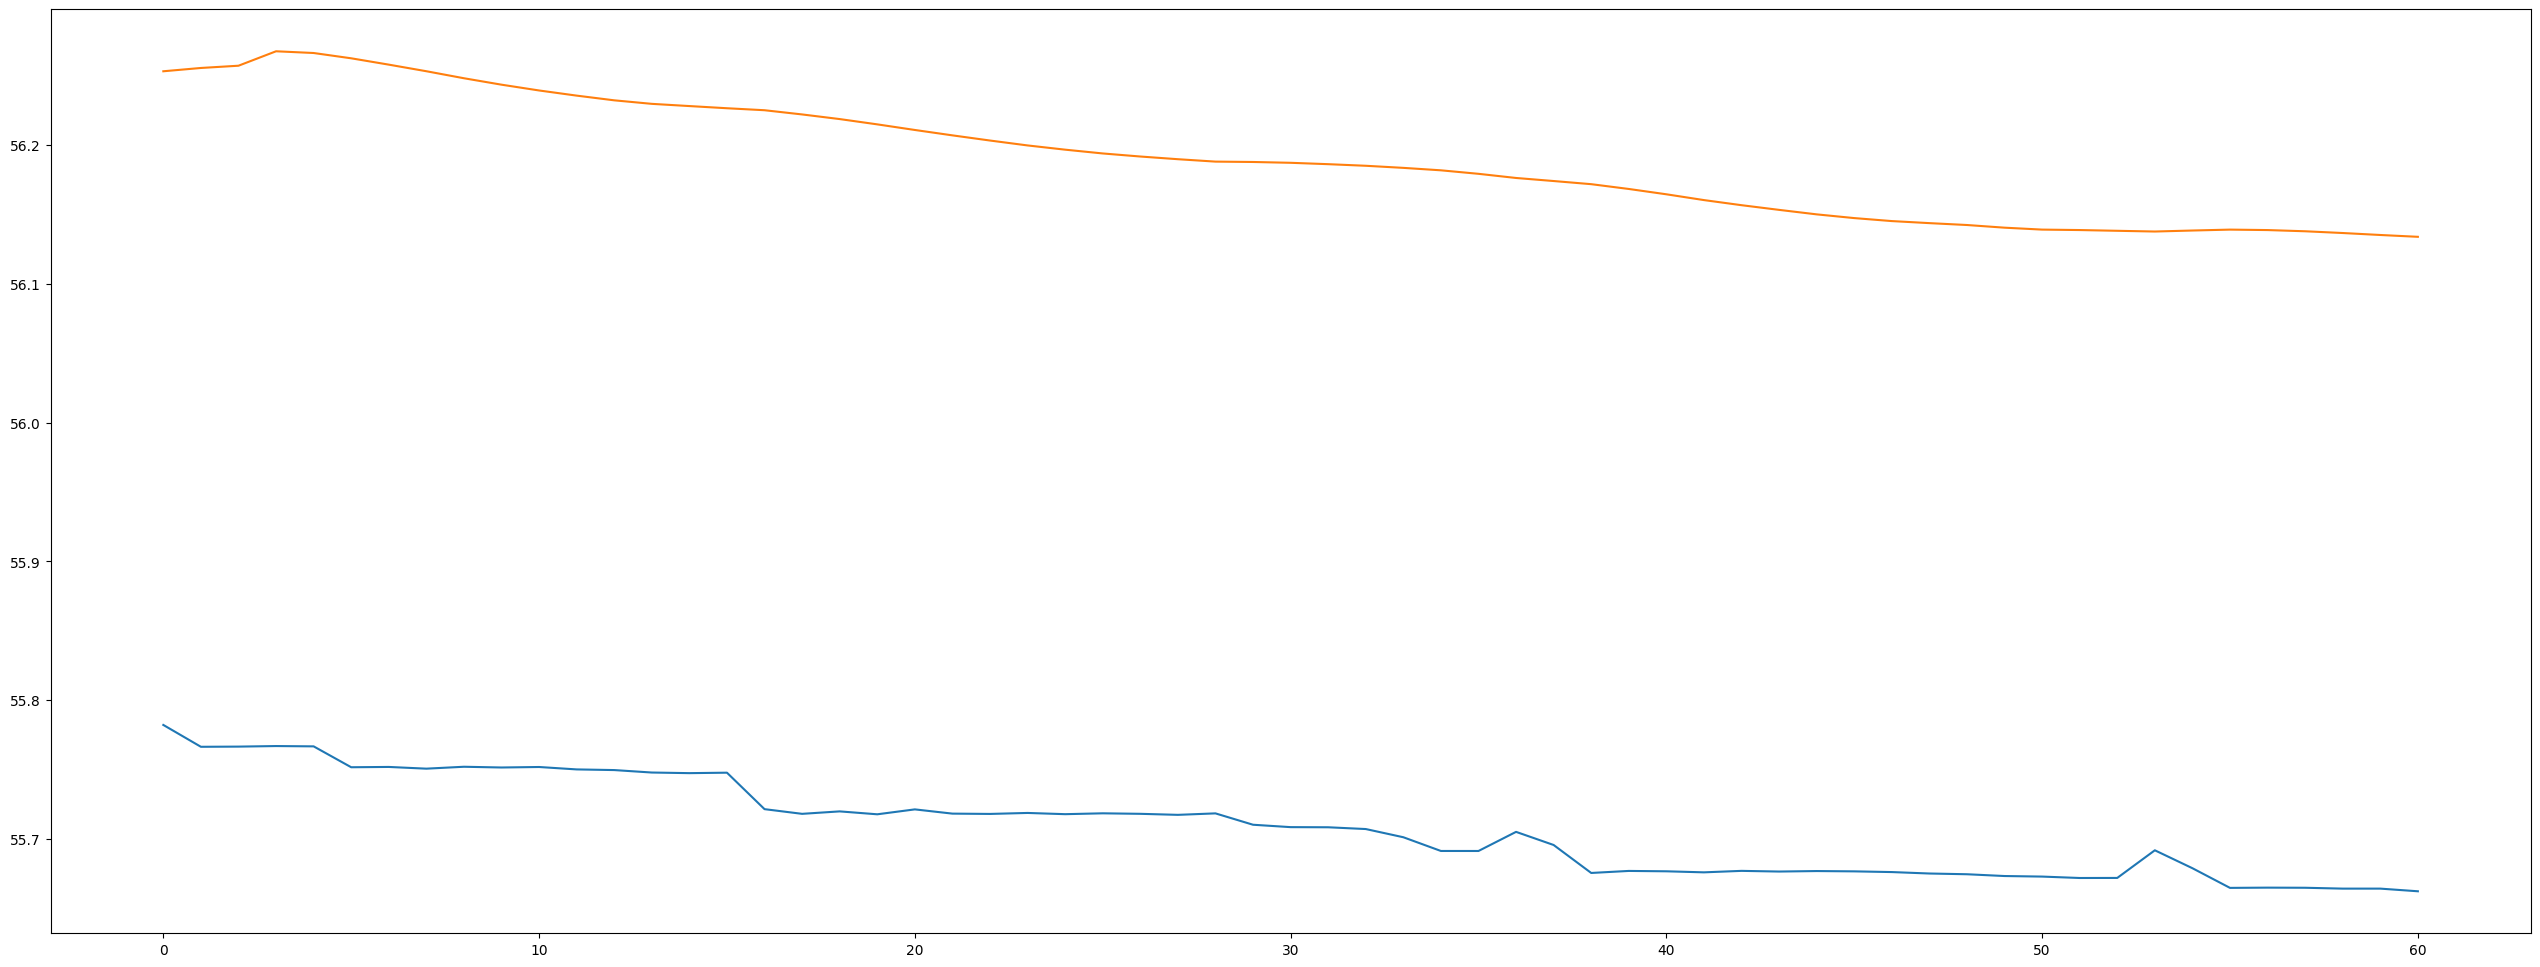

2/2 [==============================] - 0s 2ms/step


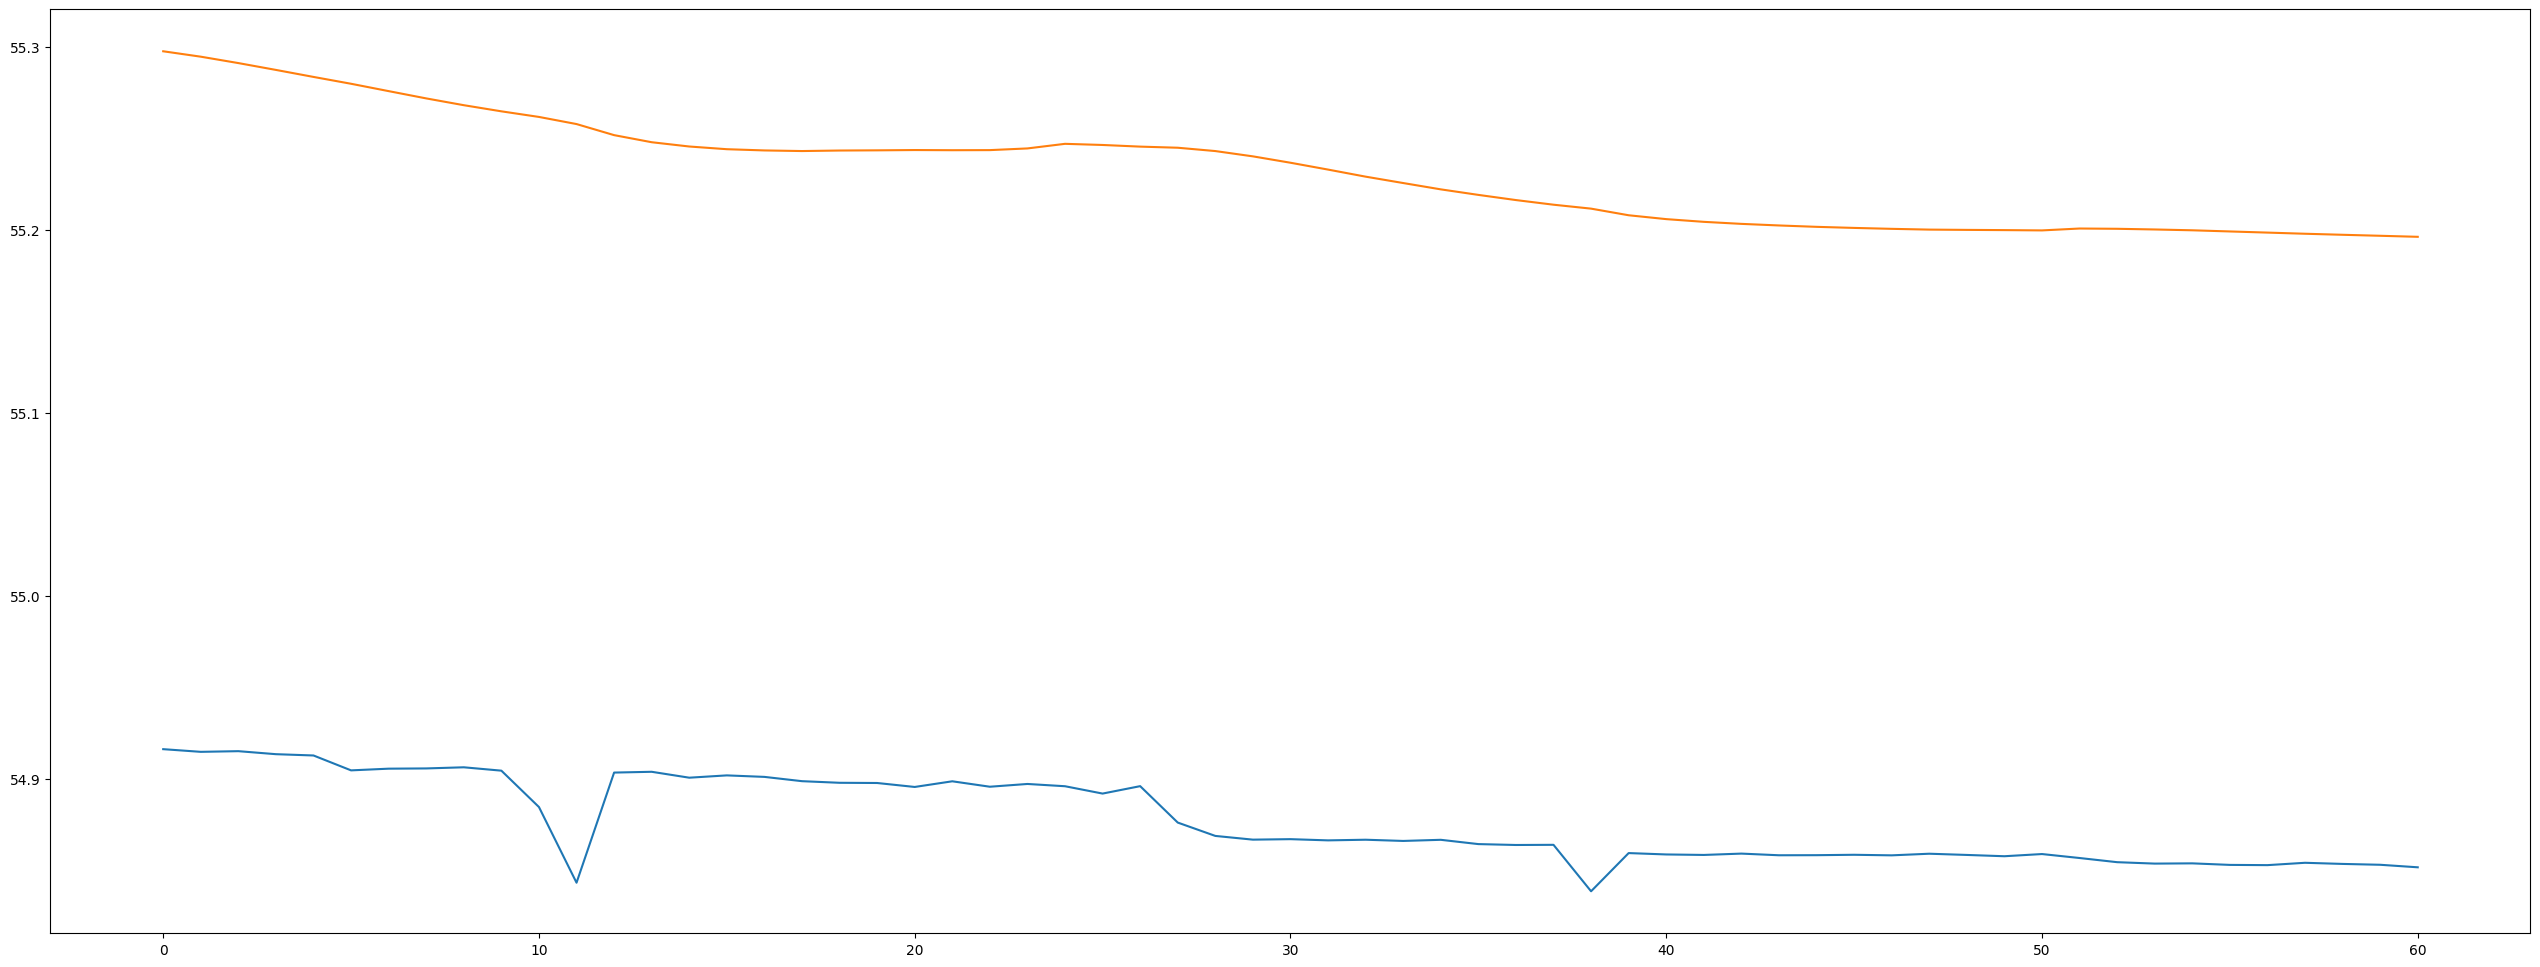

In [9]:
x_test, y_test, x_test_scale, y_test_scale = transform_data(test0, prev_day, pred_day, scaler_path)
model = model_setup(x_test_scale, pred_day)
model = tf.keras.models.load_model(model_path)

eval_each_type(test0, prev_day, pred_day, scaler_path, model)
eval_each_type(test1, prev_day, pred_day, scaler_path, model)
eval_each_type(test2, prev_day, pred_day, scaler_path, model)
eval_each_type(test3, prev_day, pred_day, scaler_path, model)

# One prediction comparison

In [10]:
df1 = pd.read_csv(eval_path).tail(prev_day + pred_day)
df1 = df1.set_index('timestamp')
col = df1.columns

x_test, y_test, x_test_scale, y_test_scale = transform_data(df1, prev_day, pred_day, scaler_path)

model = model_setup(x_test_scale, pred_day)
model = tf.keras.models.load_model(model_path)

preds = model.predict(x_test_scale)
scaler = joblib.load(scaler_path + '/scaler_labels.pkl')
preds = scaler.inverse_transform(preds)

test_score(preds, y_test, pred_day)

1/1 [==============================] - 0s 273ms/step
Test Score: 1.65 RMSE
Test Score: 1.010265 MAE
Test Score: 1.495048 MAPE
*** Accuracy:  98.50495170497122


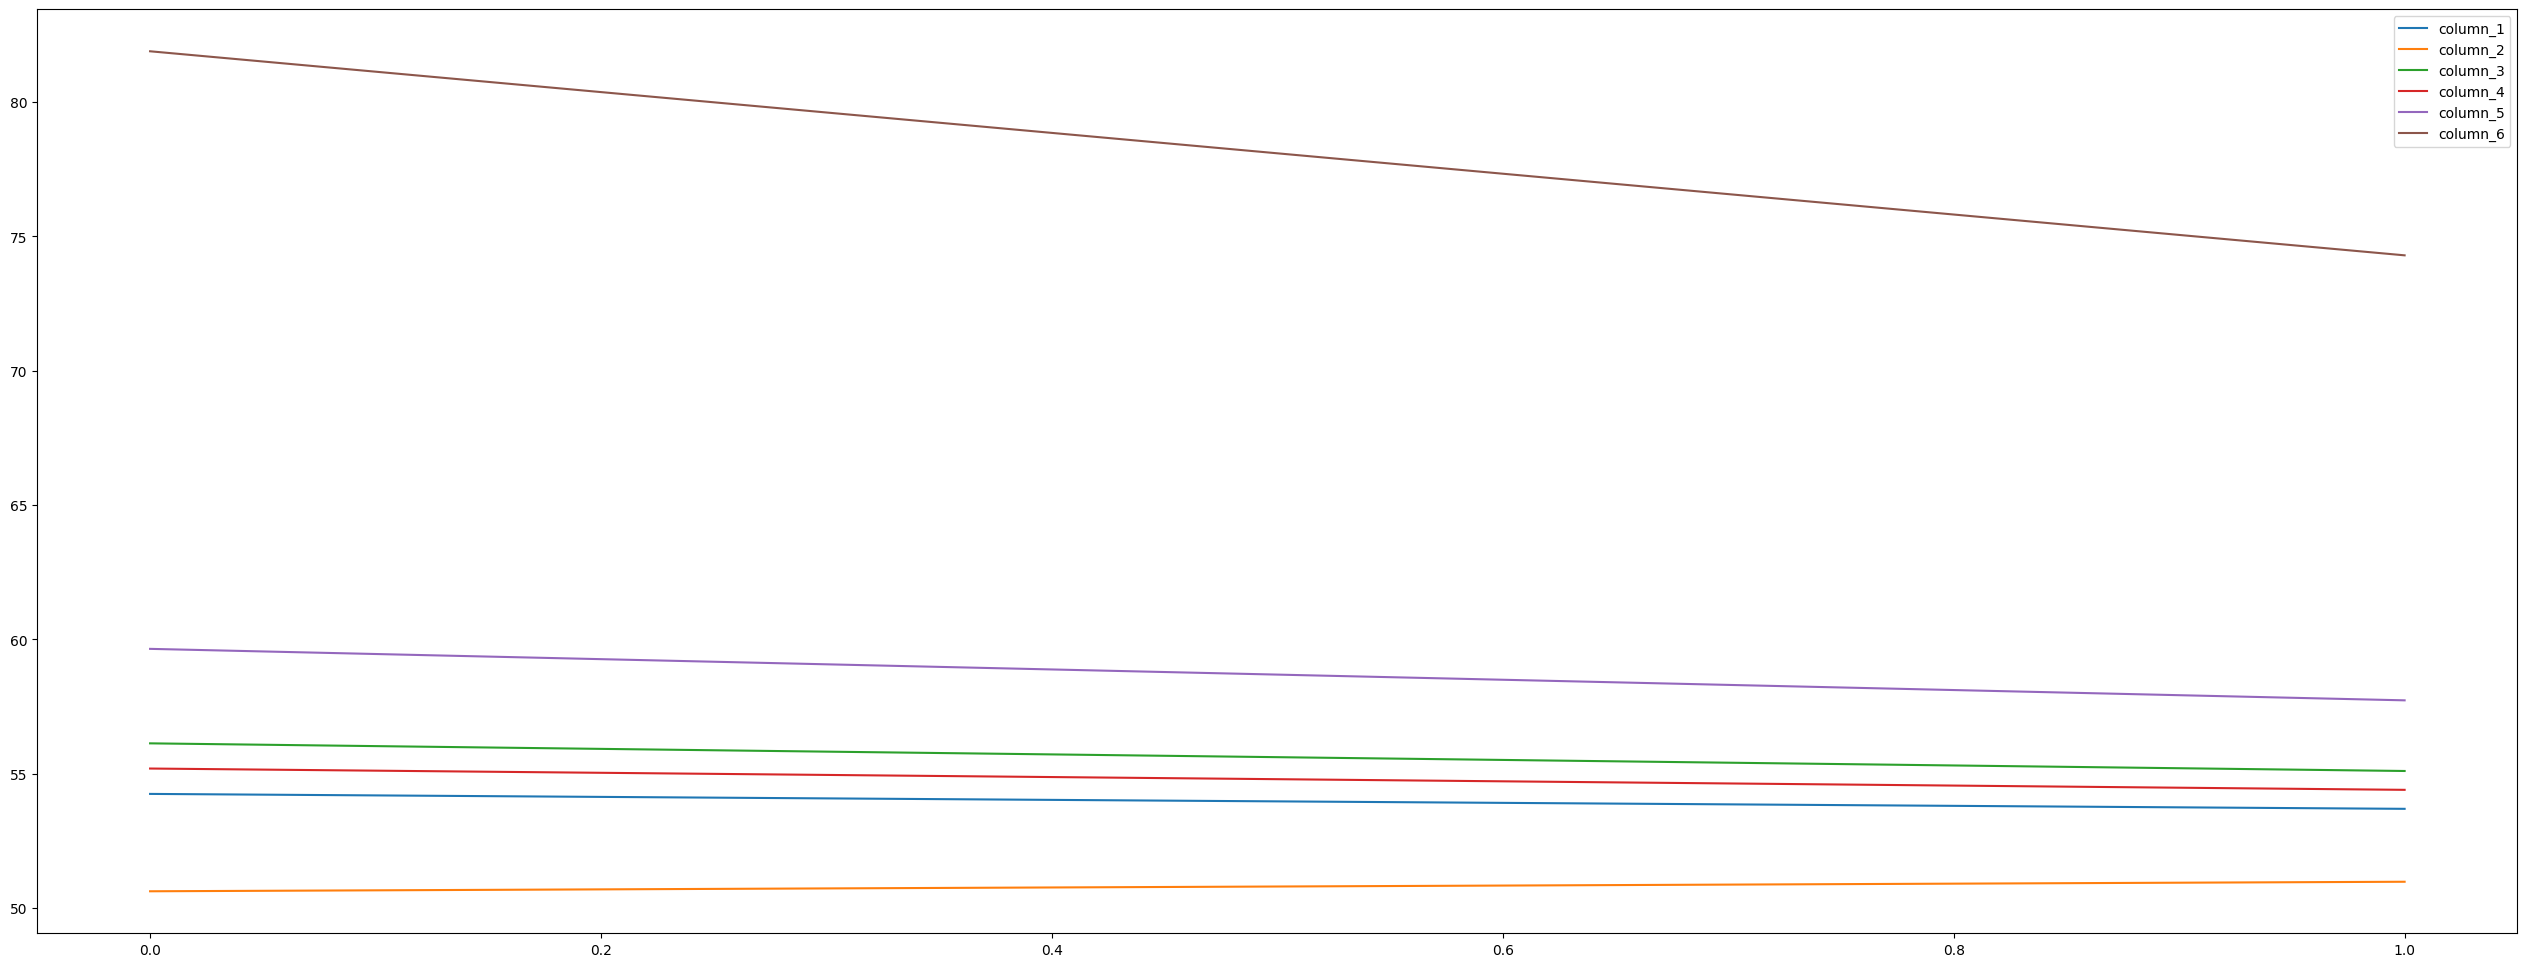

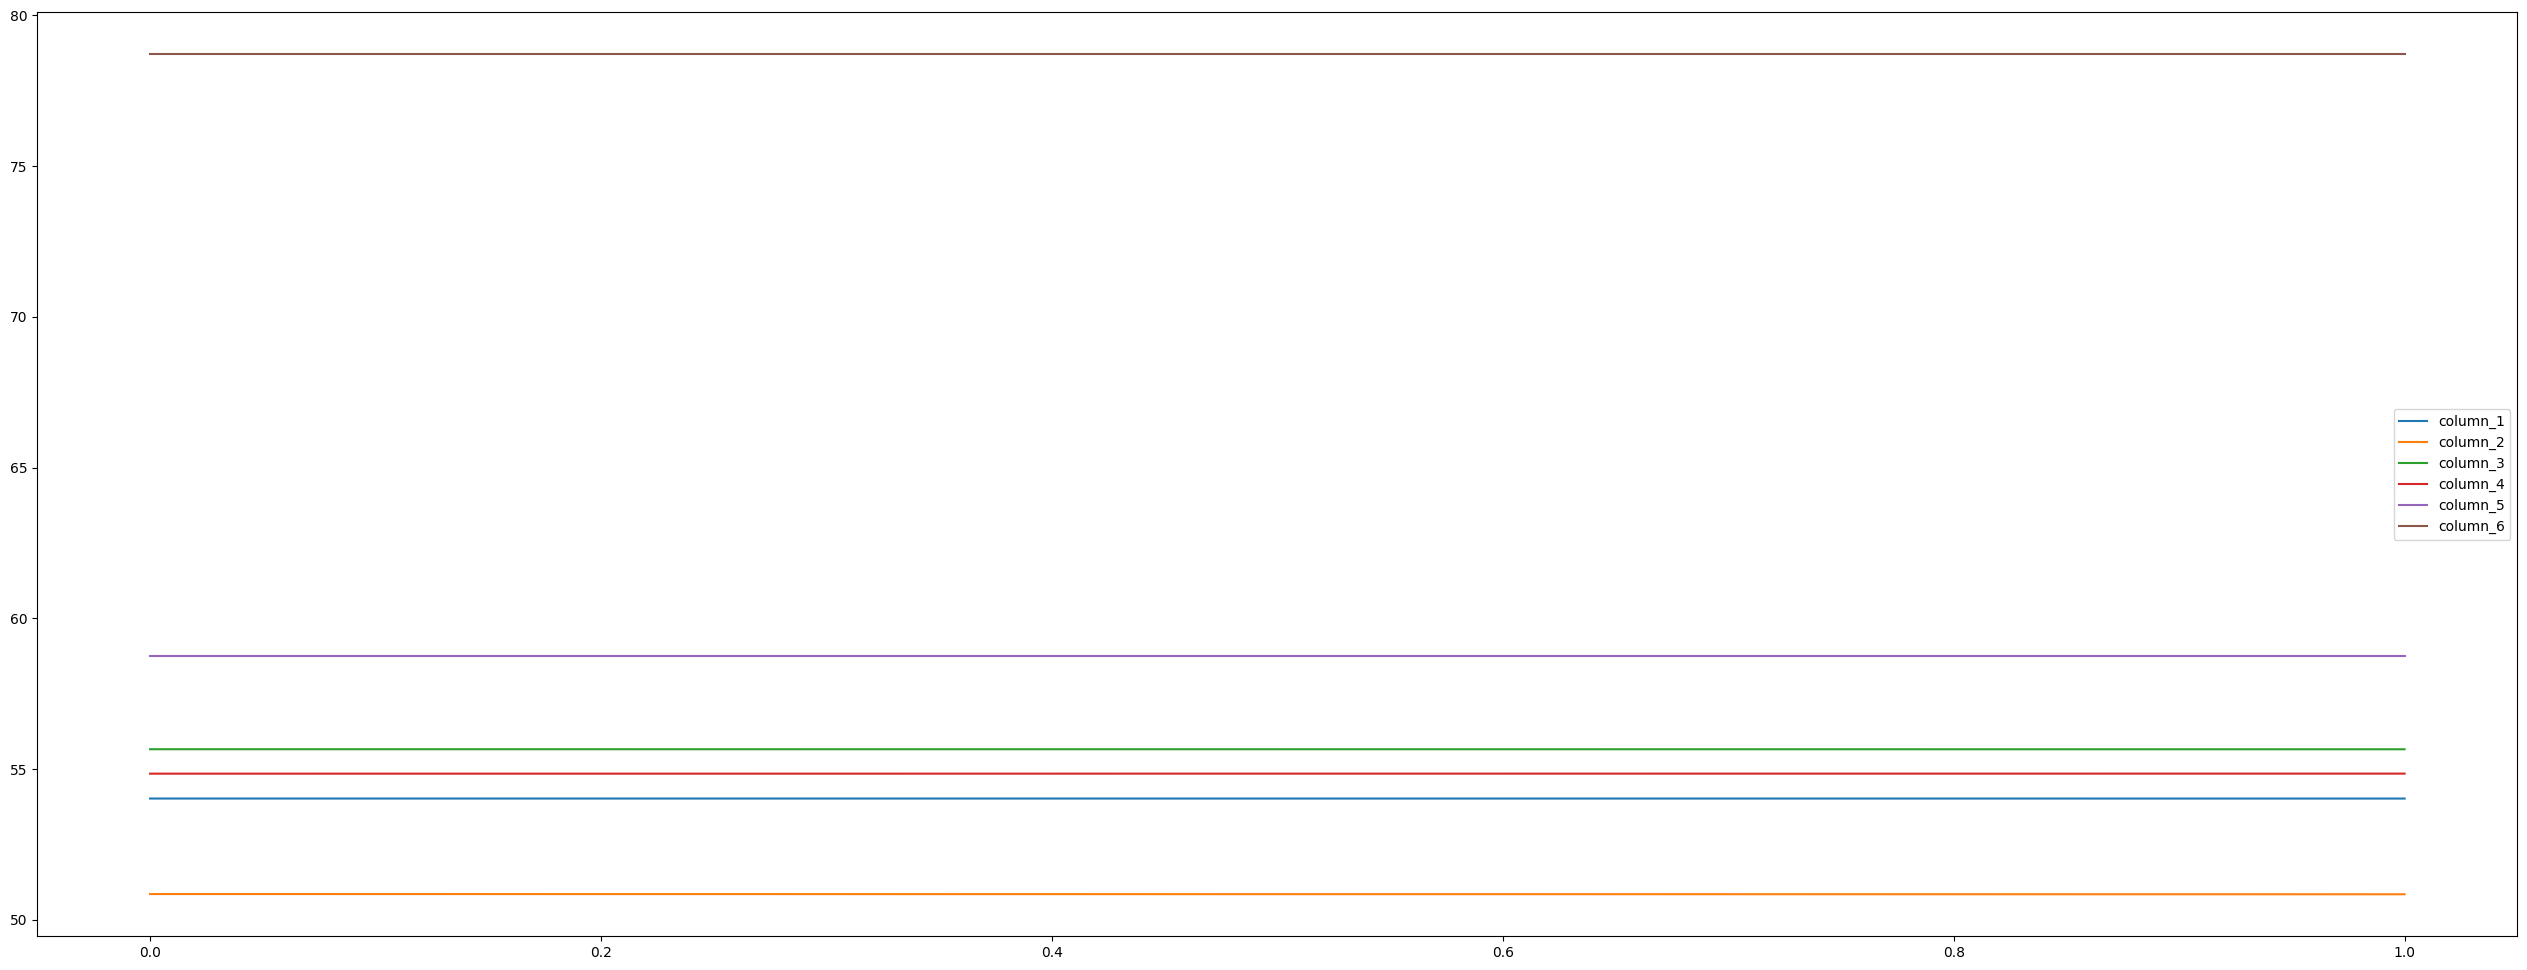

In [11]:

# Create a dictionary where keys are column names and values are sub-arrays
df1 = pd.DataFrame(preds.T, columns=[f"column_{i+1}" for i in range(preds.shape[0])])

# Create a dictionary where keys are column names and values are sub-arrays
df2 = pd.DataFrame(y_test.T, columns=[f"column_{i+1}" for i in range(preds.shape[0])])

df1.plot()
df2.plot()
plt.show()


In [12]:
df1.columns = col
df1

,amphora-00106840-3bfa-43d0-acdb-5fa78683d8ca,amphora-002a6401-7521-485b-a4fb-ede70de13870,amphora-0067676d-0ad2-4358-aa8b-cc9fbf926250,amphora-007a71c6-7f2c-42d7-ab40-3379953f1235,amphora-00853e9d-5b93-4ca2-86c1-ef4a1d9fe87e,amphora-0160da0f-e220-439b-9480-418c5c296531
0,54.252056,50.628784,56.133747,55.196362,59.649876,81.887726
1,53.696930,50.983402,55.105019,54.403687,57.734066,74.294044


In [13]:
df2.columns = col
df2

,amphora-00106840-3bfa-43d0-acdb-5fa78683d8ca,amphora-002a6401-7521-485b-a4fb-ede70de13870,amphora-0067676d-0ad2-4358-aa8b-cc9fbf926250,amphora-007a71c6-7f2c-42d7-ab40-3379953f1235,amphora-00853e9d-5b93-4ca2-86c1-ef4a1d9fe87e,amphora-0160da0f-e220-439b-9480-418c5c296531
0,54.027125,50.859012,55.662418,54.851733,58.743545,78.713041
1,54.026196,50.851182,55.660615,54.853624,58.743545,78.713041
